# Mellin transform via Chebyshev polynomials

The idea is to approximate the Mellin transform of the single exponential using the Chebyshev polynomials, and then write this expansion in powers of $e^{-a \omega}$.

## Definition of functions

In [125]:
import numpy as np
import scipy as sp
import mpmath as mp
import matplotlib.pyplot as plt

plt.style.use("my_style.mplstyle")

def cheb_coeff(f, N, endpoint = True):
    if endpoint:
        N += 1
    nvals = np.arange(N)
    nodes = np.zeros(N)
    nodes[0:int(N/2)] = np.cos(np.pi*(nvals[0:int(N/2)]+0.5)/N)
    nodes[int(N/2)+N%2:N] = -np.flip(nodes[0:int(N/2)])
    return np.array([2*np.sum(f(nodes)*sp.special.chebyt(j)(nodes))/N for j in nvals], dtype = complex)

def cheb_approx(x, coeff):
    nvals = np.arange(0, len(coeff))
    poly = np.array([sp.special.chebyt(k)(x) for k in nvals])
    return np.sum(np.diag(coeff) @ poly, axis = 0) - 0.5*coeff[0]

def B_nk(N, w0 = 0):
    B = np.zeros((N+1, N+1))
    t_prev, t, tmp = np.zeros(max(N+1, 2)), np.zeros(max(N+1, 2)), np.zeros(max(N+1, 2))
    t_prev[0], t[0], t[1] = 1, -1, 2*np.exp(w0)
    B[0, :], B[1, :] = t_prev, t
    for n in range(1, N):
        tmp[0] = -2*t[0]-t_prev[0]
        tmp[1:n+2] = 4*np.exp(w0)*t[0:n+1]
        tmp[1:n+1] -= 2*t[1:n+1]
        tmp[1:n] -= t_prev[1:n]
        t_prev[:] = t[:]
        t[:] = tmp[:]
        B[n+1, :] = t
    return B

def cheb_coeff_int(f, N, endpoint = True):
    if endpoint:
        N = N+1
    fcos = lambda theta: f(np.cos(theta)) * np.cos(np.arange(0, N)*theta)
    return sp.integrate.quad_vec(fcos, 0, np.pi)[0]*2/np.pi
        

## Approximation of the continuum Mellin transform with Chebyshev polinomials

First of all, to test the code, we apply the machinery to the gaussian distribution. Then we will move to the actual Mellin transform.

### Gaussian distribution

In [166]:
# Coefficients of a Gaussian
N = [5, 15, 25, 35, 50, 70]
mu, sigma = 1, 1
f = lambda x: sp.stats.norm(mu, sigma).pdf(-np.log((x+1)/2))

coeff = np.zeros((len(N), max(N)), dtype = complex)
for ni in range(len(N)):
    coeff[ni, :N[ni]] = cheb_coeff(f, N[ni])

Text(0.5, 1.0, 'Coefficients for the Gaussian distribution, $\\mu = 1$, $\\sigma = 1$')

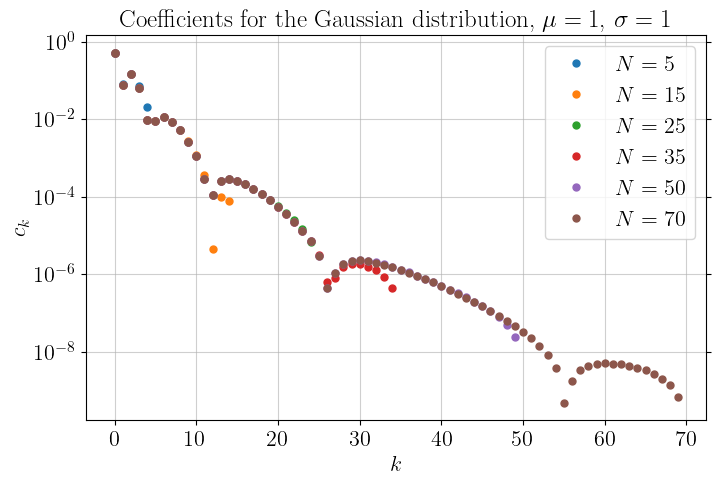

In [167]:
for ni in range(len(N)):
    plt.plot(np.abs(coeff[ni]), "o", markersize = 5, label=r"$N = {}$".format(N[ni]))
plt.legend()
plt.semilogy()
plt.xlabel(r"$k$")
plt.ylabel(r"$c_k$")
plt.title(r"Coefficients for the Gaussian distribution, $\mu = {}$, $\sigma = {}$".format(mu, sigma))

We observe that the first coefficients are very similar even if we increase $N$, and then they go rapidly to zero. To see if these coefficients are correct, let's try to reproduce the function itself.

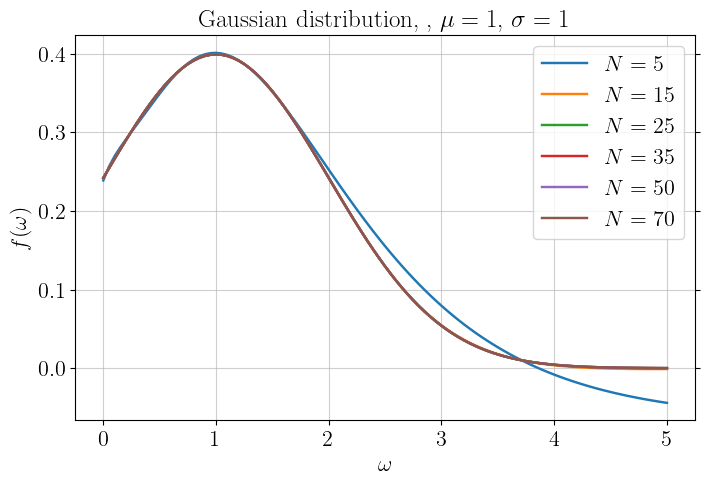

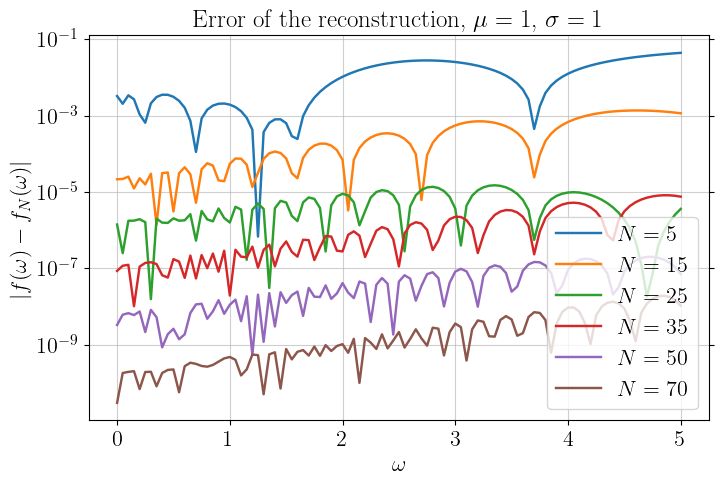

In [168]:
xgrid = np.linspace(0.0001, 5, 101)
for ni in range(len(N)):
    plt.plot(xgrid, cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).real, label=r"$N = {}$".format(N[ni]))
plt.legend()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$f(\omega)$")
plt.title(r"Gaussian distribution, , $\mu = {}$, $\sigma = {}$".format(mu, sigma))
plt.show()

for ni in range(len(N)):
    plt.plot(xgrid, np.abs(cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).real-sp.stats.norm(1, 1).pdf(xgrid)), label=r"$N = {}$".format(N[ni]))
plt.legend()
plt.semilogy()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$|f(\omega)-f_N(\omega)|$")
plt.title(r"Error of the reconstruction, $\mu = {}$, $\sigma = {}$".format(mu, sigma))
plt.show()

Increasing the number of polynomial, we get a better and better approximation.

We now try to compute the coefficients using the integral expression.

In [92]:
# Coefficients of a Gaussian
N = np.array([5, 10, 15, 20])
mu, sigma = 1, 1
f = lambda x: sp.stats.norm(mu, sigma).pdf(-np.log((x+1)/2))

coeff = np.zeros((len(N), max(N+1)), dtype = complex)
for ni in range(len(N)):
    coeff[ni, :N[ni]+1] = cheb_coeff_int(f, N[ni])

Text(0.5, 1.0, 'Coefficients for the Gaussian distribution, $\\mu = 1$, $\\sigma = 1$')

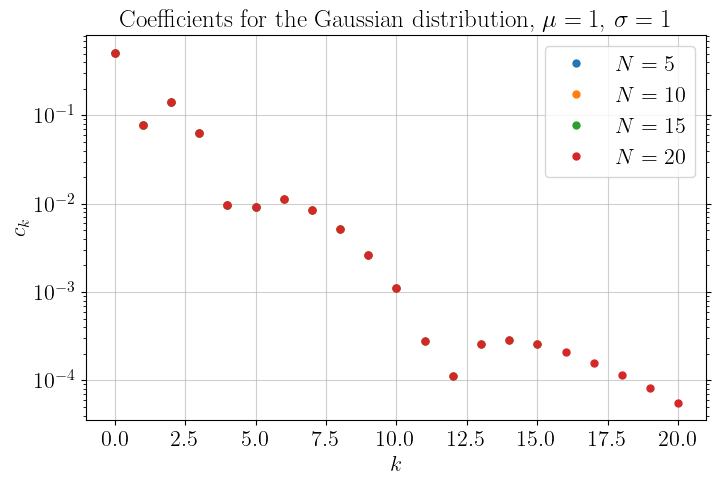

In [93]:
for ni in range(len(N)):
    plt.plot(np.abs(coeff[ni]), "o", markersize = 5, label=r"$N = {}$".format(N[ni]))
plt.legend()
plt.semilogy()
plt.xlabel(r"$k$")
plt.ylabel(r"$c_k$")
plt.title(r"Coefficients for the Gaussian distribution, $\mu = {}$, $\sigma = {}$".format(mu, sigma))

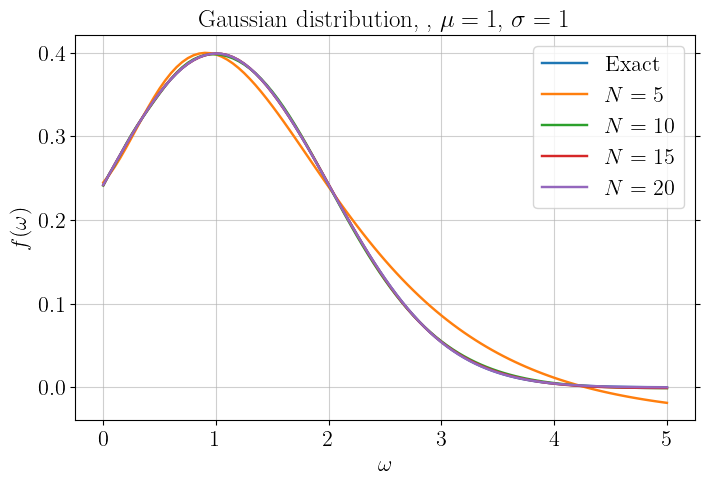

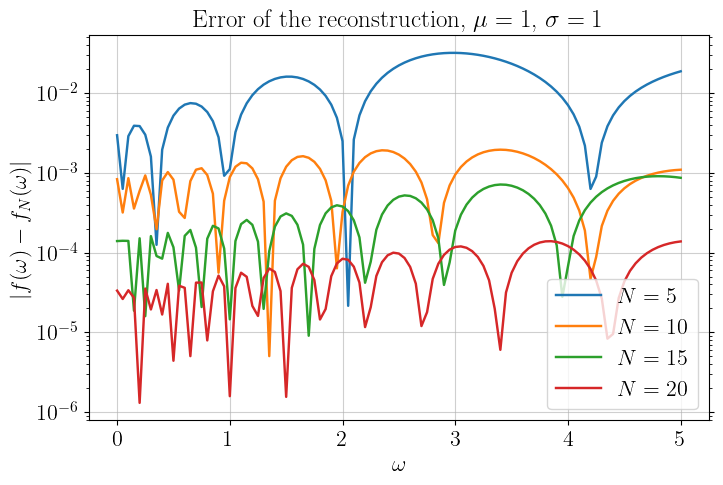

In [100]:
xgrid = np.linspace(0, 5, 101)
plt.plot(xgrid, sp.stats.norm(1, 1).pdf(xgrid), label = "Exact")
for ni in range(len(N)):
    plt.plot(xgrid, cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).real, label=r"$N = {}$".format(N[ni]))
plt.legend()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$f(\omega)$")
plt.title(r"Gaussian distribution, , $\mu = {}$, $\sigma = {}$".format(mu, sigma))
plt.show()

for ni in range(len(N)):
    plt.plot(xgrid, np.abs(cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).real-sp.stats.norm(1, 1).pdf(xgrid)), label=r"$N = {}$".format(N[ni]))
plt.legend()
plt.semilogy()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$|f(\omega)-f_N(\omega)|$")
plt.title(r"Error of the reconstruction, $\mu = {}$, $\sigma = {}$".format(mu, sigma))
plt.show()

### Mellin transform

In [343]:
N = [10, 40, 80, 120, 500]
s = 1
w0 = 270*0.065/197.3*2
f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s)

coeff = np.zeros((len(N), max(N)), dtype = complex)
for ni in range(len(N)):
    coeff[ni, :N[ni]] = cheb_coeff(f, N[ni])

/tmp/ipykernel_21121/3975656979.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.abs(coeff[ni].real - coeff[-1].real)/coeff[ni].real, "o", markersize = 3, label=r"$N = {}$".format(N[ni]))


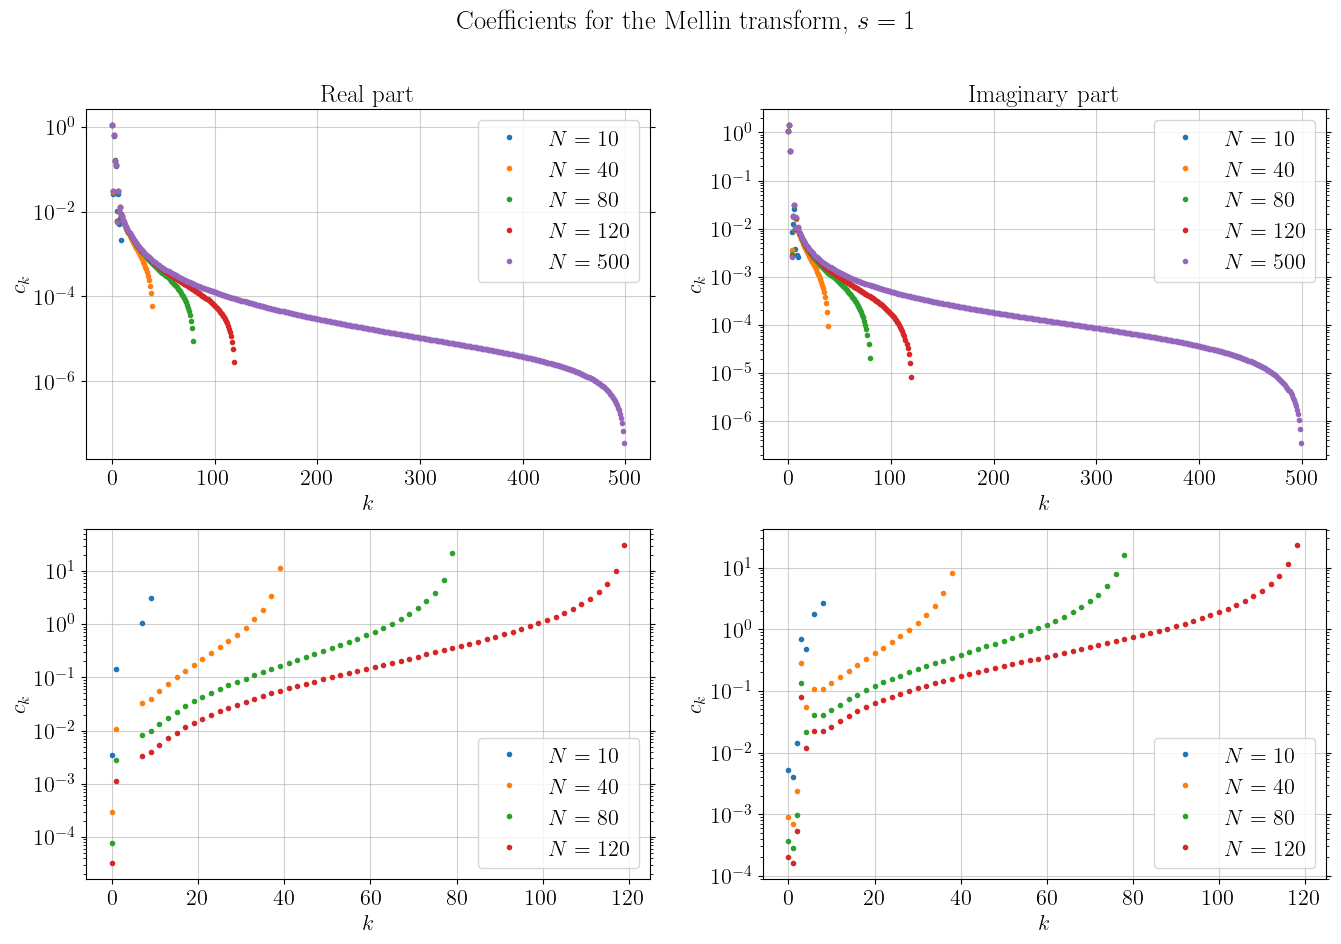

In [344]:
plt.figure(figsize = [16, 10])
plt.subplot(2, 2, 1)
for ni in range(len(N)):
    plt.plot(np.abs(coeff[ni].real), "o", markersize = 3, label=r"$N = {}$".format(N[ni]))
plt.semilogy()
#plt.semilogx()
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$c_k$")
plt.title(r"Real part")

plt.subplot(2, 2, 2)
for ni in range(len(N)):
    plt.plot(np.abs(coeff[ni].imag), "o", markersize = 3, label=r"$N = {}$".format(N[ni]))
plt.semilogy()
#plt.semilogx()
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$c_k$")
plt.title(r"Imaginary part")

plt.subplot(2, 2, 3)
for ni in range(len(N)-1):
    plt.plot(np.abs(coeff[ni].real - coeff[-1].real)/coeff[ni].real, "o", markersize = 3, label=r"$N = {}$".format(N[ni]))
plt.semilogy()
#plt.semilogx()
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$c_k$")
#plt.title(r"Coefficients for the Mellin transform, $s = {}$".format(s))
plt.subplot(2, 2, 4)

for ni in range(len(N)-1):
    plt.plot(np.abs(coeff[ni, 0:N[ni]].imag - coeff[-1, 0:N[ni]].imag)/coeff[ni, 0:N[ni]].imag, "o", markersize = 3, label=r"$N = {}$".format(N[ni]))
plt.semilogy()
#plt.semilogx()
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$c_k$")
#plt.title(r"Coefficients for the Mellin transform, $s = {}$".format(s))
plt.suptitle(r"Coefficients for the Mellin transform, $s = {}$".format(s))
plt.show()

In this case, we observe a difference in the first coefficients as we increase $N$, and they don't seem to stabilize for large values of $N$.

/tmp/ipykernel_21121/3206100103.py:4: RuntimeWarning: divide by zero encountered in log
  f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s)


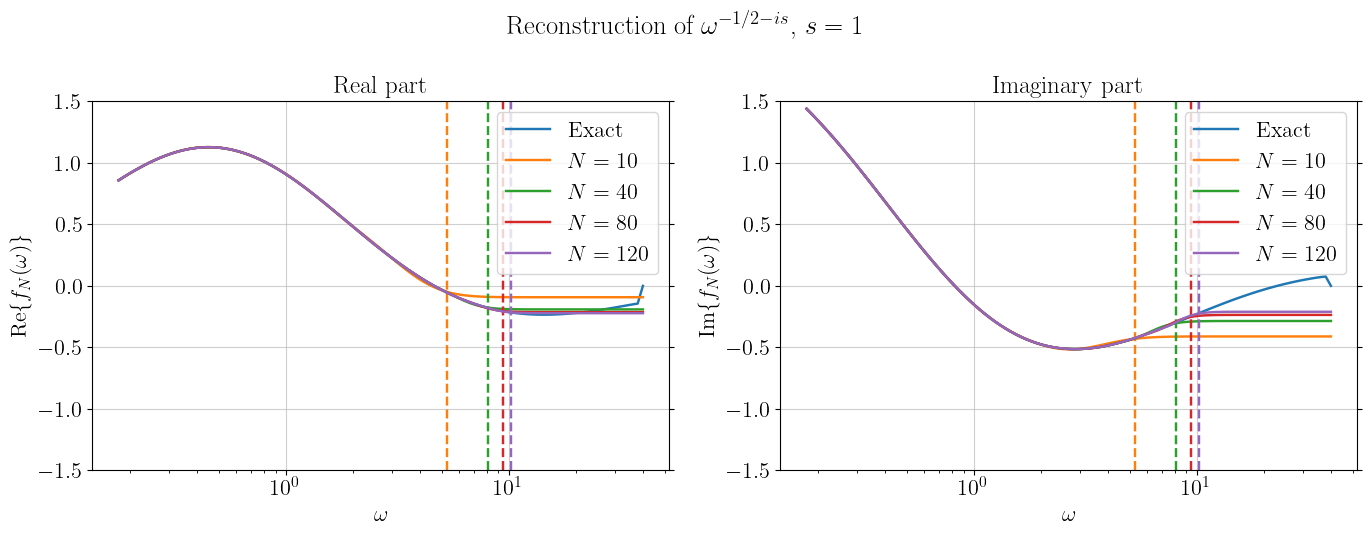

/tmp/ipykernel_21121/3206100103.py:4: RuntimeWarning: divide by zero encountered in log
  f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s)


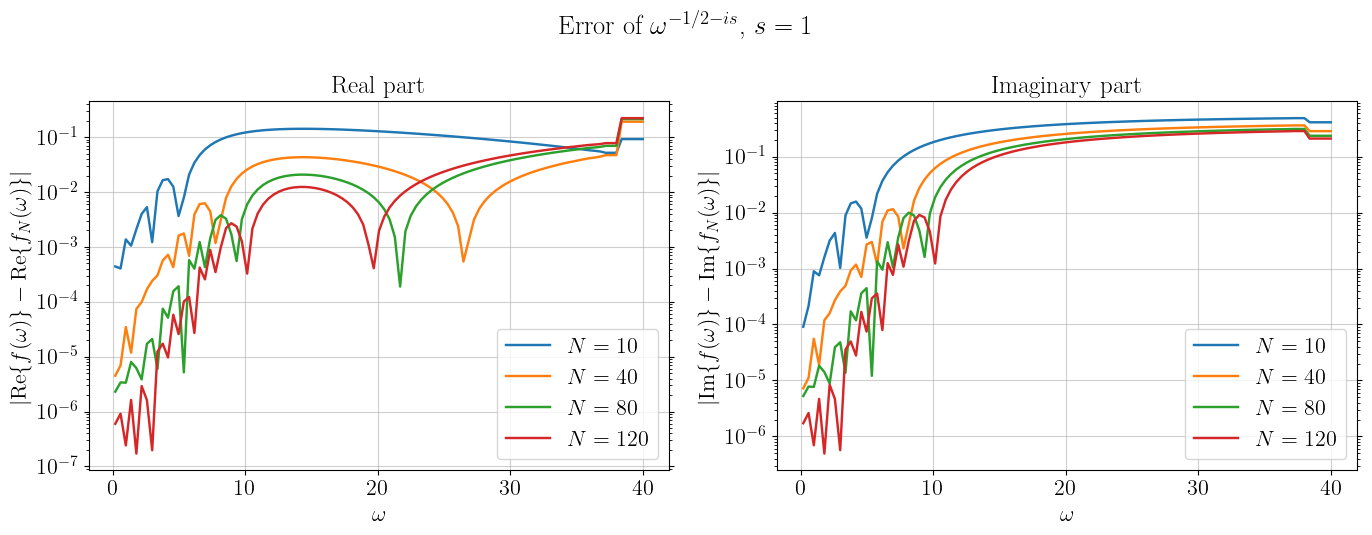

In [336]:
plt.figure(figsize=[14, 5.5])
plt.subplot(1, 2, 1)
xgrid = np.logspace(np.log10(w0), np.log10(40), 101)
plt.plot(xgrid, f(2*np.exp(-xgrid)-1).real, label="Exact")
for ni in range(len(N)):
    line, = plt.plot(xgrid, cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).real, label=r"$N = {}$".format(N[ni]))
    plt.vlines(-np.log((np.cos(np.pi*(N[ni]-0.5)/N[ni])+1)/(2*np.exp(w0))), -1.5, 1.5, colors = line.get_color(), linestyles="dashed")
plt.legend()
plt.semilogx()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\mathrm{Re}\{f_N(\omega)\}$")
plt.ylim(-1.5, 1.5)
plt.title(r"Real part")

plt.subplot(1, 2, 2)
plt.plot(xgrid, f(2*np.exp(-xgrid)-1).imag, label="Exact")
for ni in range(len(N)):
    line, = plt.plot(xgrid, cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).imag, label=r"$N = {}$".format(N[ni]))
    plt.vlines(-np.log((np.cos(np.pi*(N[ni]-0.5)/N[ni])+1)/(2*np.exp(w0))), -1.5, 1.5, colors = line.get_color(), linestyles="dashed")
plt.legend()
plt.semilogx()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\mathrm{Im}\{f_N(\omega)\}$")
plt.ylim(-1.5, 1.5)
plt.title(r"Imaginary part")
plt.suptitle(r"Reconstruction of $\omega^{-1/2-is}$, "+r"$s={}$".format(s))
plt.tight_layout()
plt.show()

plt.figure(figsize=[14, 5.5])
plt.subplot(1, 2, 1)
xgrid = xgrid = np.linspace(w0, 40, 101)
for ni in range(len(N)):
    plt.plot(xgrid, np.abs(cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).real-f(2*np.exp(-xgrid)-1).real), label=r"$N = {}$".format(N[ni])) 
plt.legend()
plt.semilogy()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$|\mathrm{Re}\{f(\omega)\} - \mathrm{Re}\{f_N(\omega)\}|$") 
plt.title(r"Real part")

plt.subplot(1, 2, 2)
for ni in range(len(N)):
    plt.plot(xgrid, np.abs(cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).imag-f(2*np.exp(-xgrid)-1).imag), label=r"$N = {}$".format(N[ni]))
plt.legend()
plt.semilogy()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$|\mathrm{Im}\{f(\omega)\} - \mathrm{Im}\{f_N(\omega)\}|$")
plt.title(r"Imaginary part")
plt.suptitle(r"Error of $\omega^{-1/2-is}$, "+r"$s={}$".format(s))
plt.tight_layout()
plt.show()

In [103]:
N = 100
s = np.array([0, 2.5, 5, 7.5, 10])
w0 = 270*0.065/197.3

coeff = np.zeros((len(s), N+1), dtype = complex)
for si in range(len(s)):
    f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s[si])
    coeff[si, :] = cheb_coeff_int(f, N)

/tmp/ipykernel_738/401202315.py:7: RuntimeWarning: divide by zero encountered in log
  f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s[si])
/tmp/ipykernel_738/401202315.py:7: RuntimeWarning: invalid value encountered in power
  f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s[si])


Text(0.5, 1.0, 'Imaginary part')

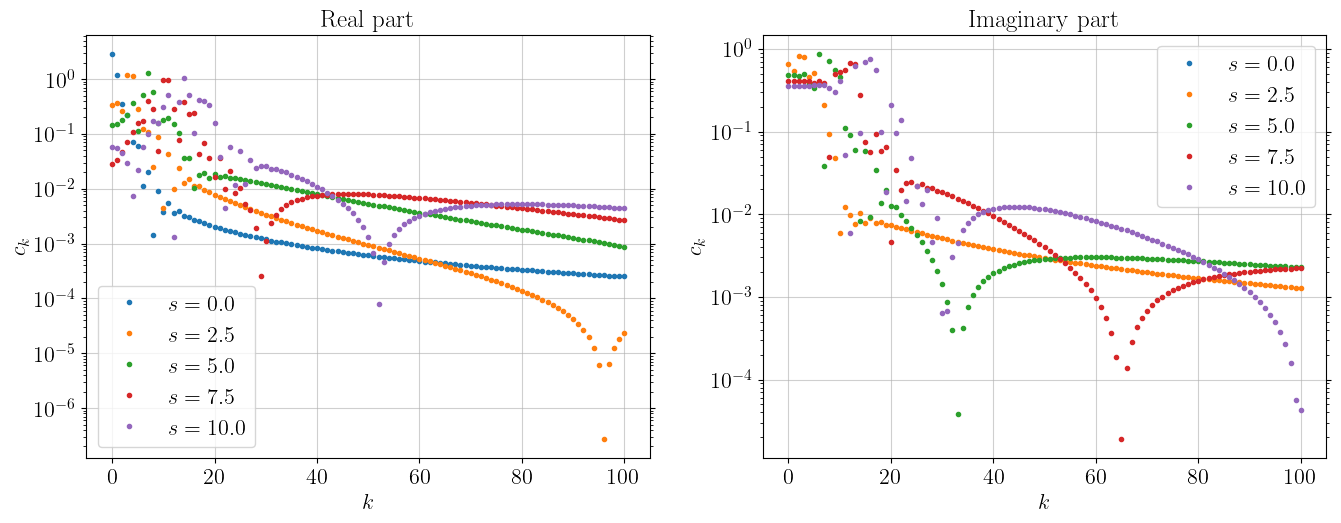

In [84]:
plt.figure(figsize = [16, 5.5])
plt.subplot(1, 2, 1)
for si in range(len(s)):
    plt.plot(np.abs(coeff[si].real), "o", markersize = 3, label=r"$s = {}$".format(s[si]))
plt.semilogy()
#plt.semilogx()
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$c_k$")
plt.title(r"Real part")

plt.subplot(1, 2, 2)
for si in range(len(s)):
    plt.plot(np.abs(coeff[si].imag), "o", markersize = 3, label=r"$s = {}$".format(s[si]))
plt.semilogy()
#plt.semilogx()
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$c_k$")
plt.title(r"Imaginary part")

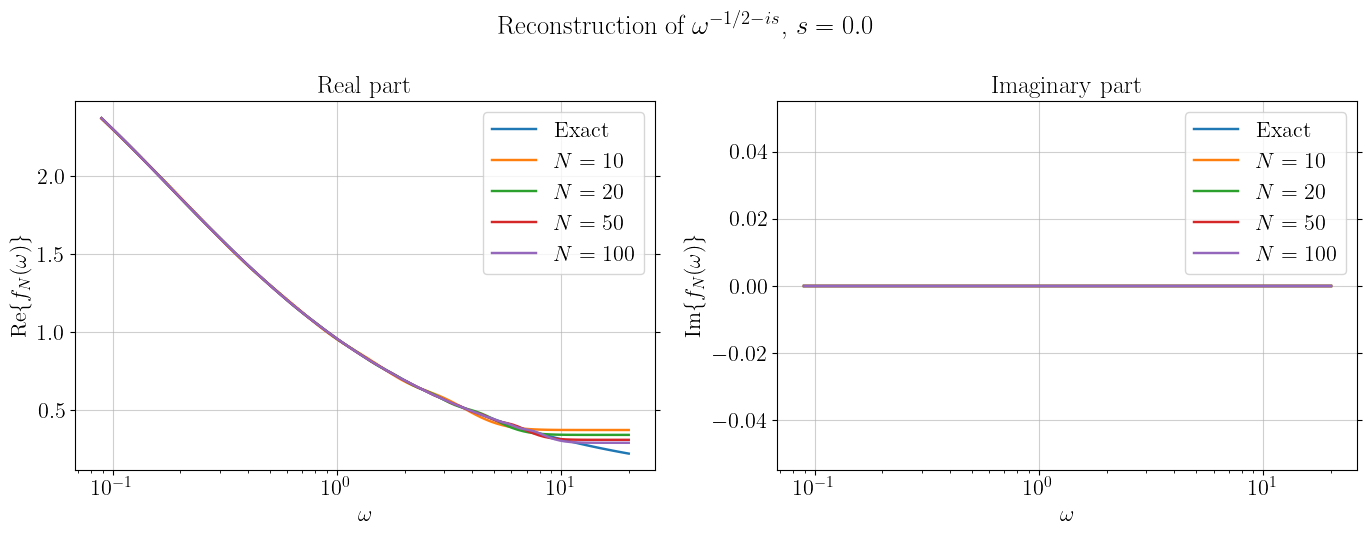

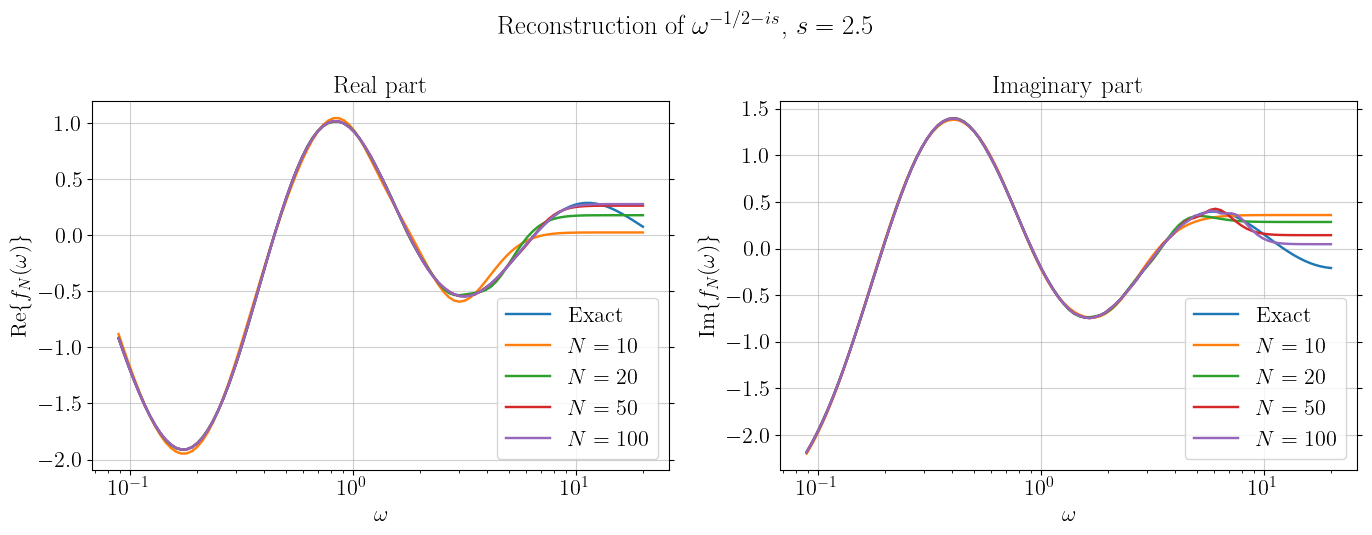

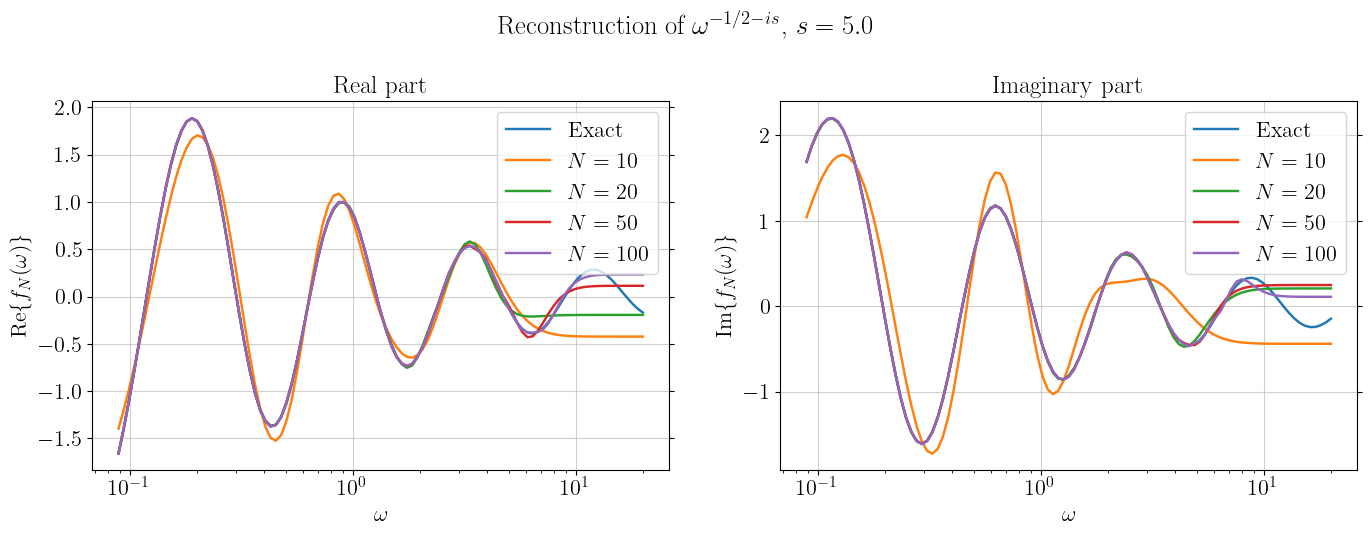

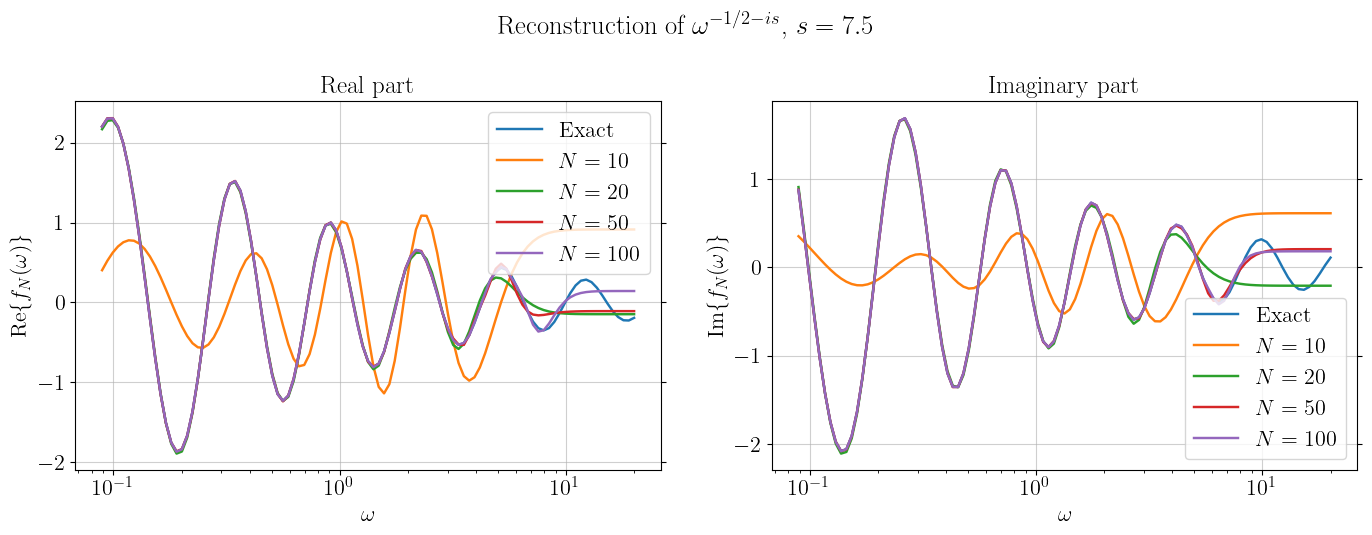

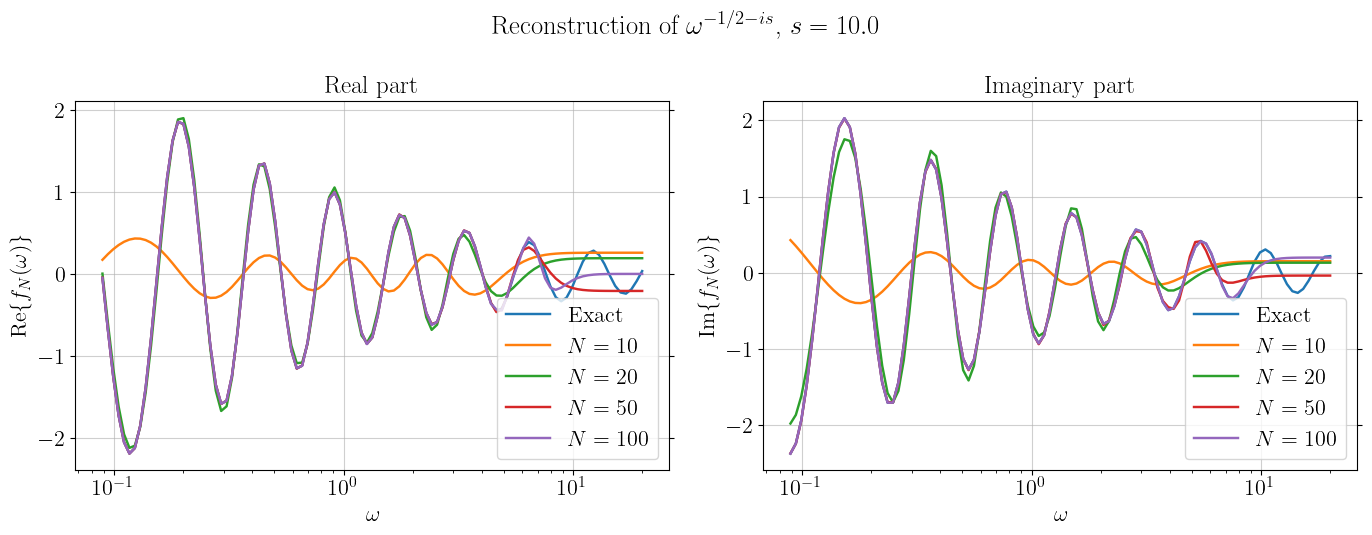

In [85]:
N = [10, 20, 50, 100]
xgrid = np.logspace(np.log10(w0+0.0001), np.log10(20-0.0001), 101)
#print(2*np.exp(-xgrid)-1)
for si in range(len(s)):
    plt.figure(figsize=[14, 5.5])
    plt.subplot(1, 2, 1)
    f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s[si])
    plt.plot(xgrid, f(2*np.exp(-xgrid)-1).real, label="Exact")
    for ni in range(len(N)):
        line, = plt.plot(xgrid, cheb_approx(2*np.exp(-xgrid)-1, coeff[si, :N[ni]+1]).real, label=r"$N = {}$".format(N[ni]))
    #plt.vlines(-np.log((np.cos(np.pi*(N[ni]-0.5)/N[ni])+1)/(2*np.exp(w0))), -1.5, 1.5, colors = line.get_color(), linestyles="dashed")
    plt.legend()
    plt.semilogx()
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$\mathrm{Re}\{f_N(\omega)\}$")
    #plt.ylim(-1.5, 1.5)
    plt.title(r"Real part")

    plt.subplot(1, 2, 2)
    plt.plot(xgrid, f(2*np.exp(-xgrid)-1).imag, label="Exact")
    for ni in range(len(N)):
        line, = plt.plot(xgrid, cheb_approx(2*np.exp(-xgrid)-1, coeff[si, :N[ni]]).imag, label=r"$N = {}$".format(N[ni]))
    #plt.vlines(-np.log((np.cos(np.pi*(N[ni]-0.5)/N[ni])+1)/(2*np.exp(w0))), -1.5, 1.5, colors = line.get_color(), linestyles="dashed")
    plt.legend()
    plt.semilogx()
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$\mathrm{Im}\{f_N(\omega)\}$")
    #plt.ylim(-1.5, 1.5)
    plt.title(r"Imaginary part")
    plt.suptitle(r"Reconstruction of $\omega^{-1/2-is}$, "+r"$s={}$".format(s[si]))
    plt.tight_layout()
    plt.show()

#plt.figure(figsize=[14, 5.5])
#plt.subplot(1, 2, 1)
#xgrid = xgrid = np.linspace(w0, 40, 101)
#for ni in range(len(N)):
#    plt.plot(xgrid, np.abs(cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).real-f(2*np.exp(-xgrid)-1).real), label=r"$N = {}$".format(N[ni])) 
#plt.legend()
#plt.semilogy()
#plt.xlabel(r"$\omega$")
#plt.ylabel(r"$|\mathrm{Re}\{f(\omega)\} - \mathrm{Re}\{f_N(\omega)\}|$") 
#plt.title(r"Real part")

#plt.subplot(1, 2, 2)
#for ni in range(len(N)):
#    plt.plot(xgrid, np.abs(cheb_approx(2*np.exp(-xgrid)-1, coeff[ni, :N[ni]]).imag-f(2*np.exp(-xgrid)-1).imag), label=r"$N = {}$".format(N[ni]))
#plt.legend()
#plt.semilogy()
#plt.xlabel(r"$\omega$")
#plt.ylabel(r"$|\mathrm{Im}\{f(\omega)\} - \mathrm{Im}\{f_N(\omega)\}|$")
#plt.title(r"Imaginary part")
#plt.suptitle(r"Error of $\omega^{-1/2-is}$, "+r"$s={}$".format(s))
#plt.tight_layout()
#plt.show()

## Reconstruction of the Discrete Mellin transform from the Chebyshev coefficients

In [118]:
s = np.linspace(0, 25, 201)
N = [5, 10, 15, 20]
w0 = 0.1
mell = np.zeros((len(N), len(s)), dtype = complex)


for ni in range(len(N)):
    corr = np.exp(-0.3*np.arange(0, N[ni]+1))
    B = B_nk(N[ni], w0)
    TC = (B @ corr)
    for si in range(len(s)):
        f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s[si])
        coeff = cheb_coeff(f, N[ni])
        mell[ni, si] = coeff @ TC

Text(0, 0.5, '$\\tilde{\\rho}(1-\\mathrm{S})$')

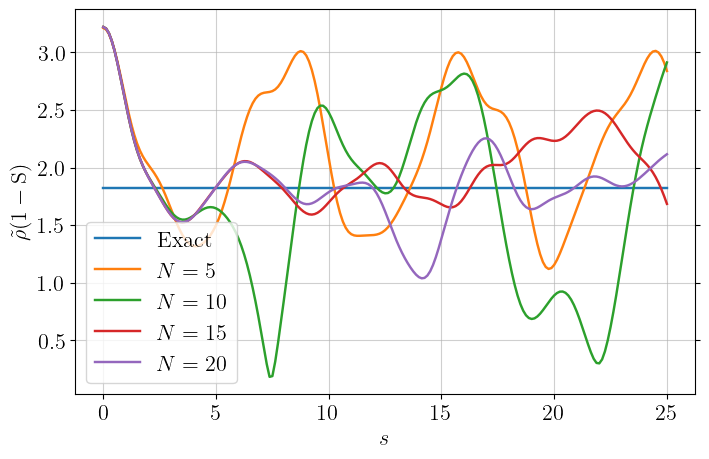

In [120]:
plt.plot(s, np.abs((0.3)**(-0.5-1j*s)), label = "Exact")
for ni in range(len(N)):
    plt.plot(s, np.abs(mell[ni]), label = r"$N = {}$".format(N[ni]))
#plt.semilogy()
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$\tilde{\rho}(1-\mathrm{S})$")

In [121]:
s = np.linspace(0, 25, 201)
N = [5, 10, 15, 20]
w0 = 0.1
mell = np.zeros((len(N), len(s)), dtype = complex)

B = B_nk(max(N), w0)
corr = np.exp(-0.3*np.arange(0, max(N)+1))
for si in range(len(s)):
    f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s[si])
    coeff = cheb_coeff_int(f, max(N))
    for ni in range(len(N)):
        TC = (B[0:N[ni]+1, 0:N[ni]+1] @ corr[0:N[ni]+1])
        mell[ni, si] = coeff[0:N[ni]+1] @ TC

/tmp/ipykernel_738/3774029396.py:9: RuntimeWarning: divide by zero encountered in log
  f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s[si])
/tmp/ipykernel_738/3774029396.py:9: RuntimeWarning: invalid value encountered in power
  f = lambda x: (-np.log((x+1)/(2*np.exp(w0))))**(-0.5-1j*s[si])


Text(0, 0.5, '$\\tilde{\\rho}(1-\\mathrm{S})$')

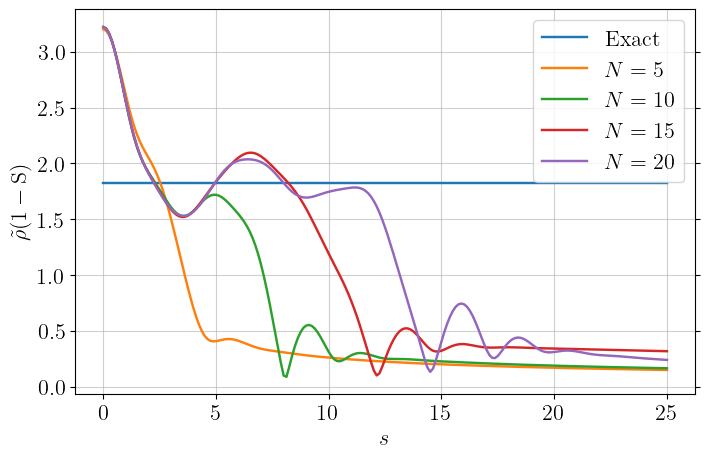

In [123]:
plt.plot(s, np.abs((0.3)**(-0.5-1j*s)), label = "Exact")
for ni in range(len(N)):
    plt.plot(s, np.abs(mell[ni]), label = r"$N = {}$".format(N[ni]))
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$\tilde{\rho}(1-\mathrm{S})$")

In [136]:
N = 22
B_nk(N, 0)
#[[N, (B_nk(N, 0)[-1:] @ np.exp(-0.3*np.arange(0, N+1)))[0]] for N in np.arange(1, 50)]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  2.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00, -8.00000000e+00,  8.00000000e+00,
         0.00000000e+00,  0.0